<a href="https://colab.research.google.com/github/MKBenjie/cats_and_dogs_classifier/blob/main/Copy_of_fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [3]:
# 3
train_image_generator = ImageDataGenerator(rescale=1.0/255.0)
validation_image_generator = ImageDataGenerator(rescale=1.0/255.0)
test_image_generator = ImageDataGenerator(rescale=1.0/255.0)

train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical'
)
val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical'
)

# importing shutil
import shutil

# Create the dummy class subdirectory if it doesn't exist
test_subdir = os.path.join(PATH, 'test', 'all')
if not os.path.exists(test_subdir):
    os.makedirs(test_subdir)

# Move all test images into the dummy class subdirectory
test_filenames = os.listdir(test_dir)
for filename in test_filenames:
    src_path = os.path.join(test_dir, filename)
    if os.path.isfile(src_path):  # Check if it's a file
        dst_path = os.path.join(test_subdir, filename)
        shutil.move(src_path, dst_path)

test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


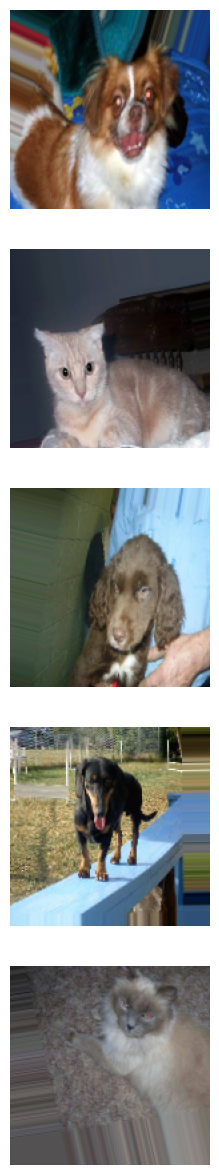

In [46]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [5]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


Found 2000 images belonging to 2 classes.


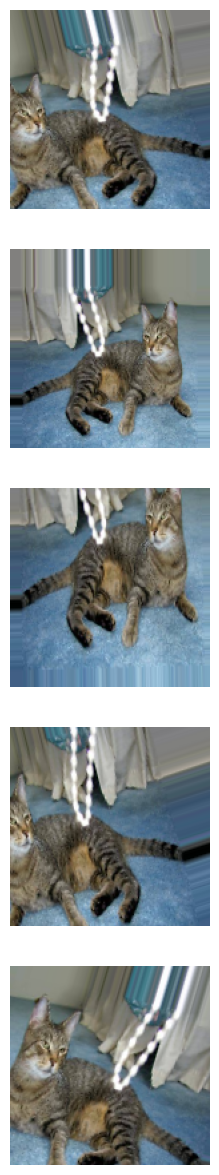

In [6]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [67]:
from keras.api._v2.keras import activations
# 7
IMG_Shape = (IMG_HEIGHT, IMG_WIDTH, 3)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_Shape,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
flattened_layer = Flatten()
intermideate_layer = Dense(512, activation='relu')
prediction_layer = Dense(1, activation='sigmoid')
dropout_layer = Dropout(0.2)
model = Sequential([
    base_model,
    flattened_layer,
    intermideate_layer,
    dropout_layer,
    prediction_layer
    ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])



model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_7 (Flatten)         (None, 32000)             0         
                                                                 
 dense_14 (Dense)            (None, 512)               16384512  
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 513       
                                                                 
Total params: 18643009 (71.12 MB)
Trainable params: 16385025 (62.50 MB)
Non-trainable params: 2257984 (8.61 MB)
________

In [68]:
# 8

train_steps_per_epoch = len(train_data_gen)
validation_steps = len(val_data_gen)
epochs = 10

history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
)

Epoch 1/10
16/16 [==============================] - 21s 1s/step - loss: 7.3535 - accuracy: 0.7635 - val_loss: 14.7587 - val_accuracy: 0.5000
Epoch 2/10
16/16 [==============================] - 17s 1s/step - loss: 0.4937 - accuracy: 0.9170 - val_loss: 10.8484 - val_accuracy: 0.5000
Epoch 3/10
16/16 [==============================] - 16s 1s/step - loss: 0.2164 - accuracy: 0.9390 - val_loss: 7.1877 - val_accuracy: 0.5000
Epoch 4/10
16/16 [==============================] - 16s 1s/step - loss: 0.1518 - accuracy: 0.9415 - val_loss: 6.1686 - val_accuracy: 0.5000
Epoch 5/10
16/16 [==============================] - 16s 994ms/step - loss: 0.1600 - accuracy: 0.9360 - val_loss: 6.3988 - val_accuracy: 0.5000
Epoch 6/10
16/16 [==============================] - 18s 1s/step - loss: 0.1283 - accuracy: 0.9530 - val_loss: 6.6415 - val_accuracy: 0.5000
Epoch 7/10
16/16 [==============================] - 16s 1s/step - loss: 0.1196 - accuracy: 0.9520 - val_loss: 6.9269 - val_accuracy: 0.5000
Epoch 8/10
16/1

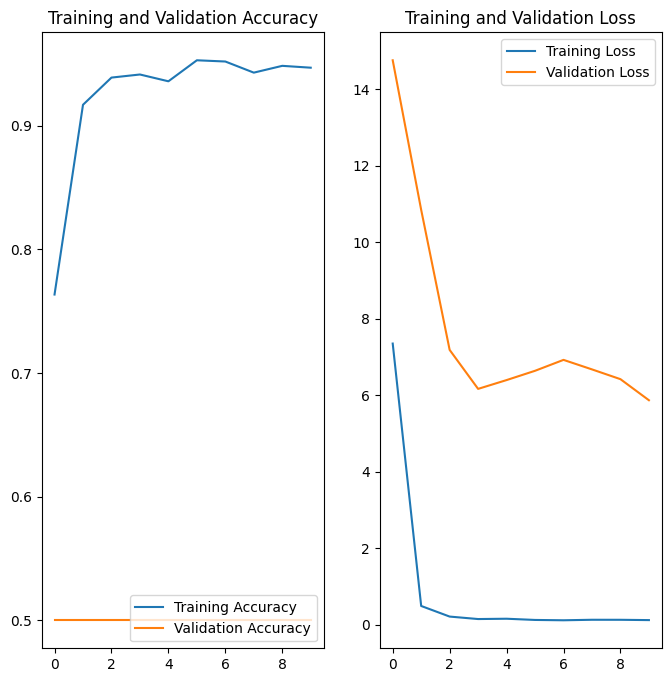

In [70]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [73]:
# Get the probabilities for each test image
probabilities = model.predict(test_data_gen)

# Convert the probabilities to integers (0 for cat, 1 for dog)
# predictions = np.argmax(probabilities, axis=1)



1/1 [==============================] - 1s 1s/step


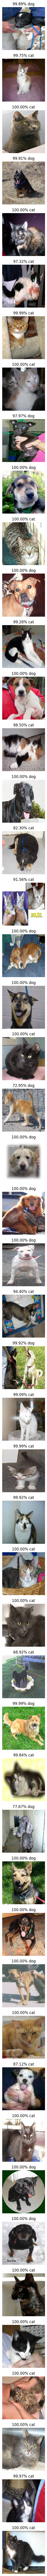

In [89]:
# test_batch, _ = next(test_data_gen)
# plotImages(test_data_gen, probabilities)
plotImages(test_data_gen[0], probabilities)

In [91]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 90.0% of the images of cats and dogs.
You passed the challenge!
